In [ ]:
# JSON Recieve Format:
# {
#     "latitude": "37.5683",
#     "longitude": "126.9778",
#     "time": "2021-11-17 13:25:02.066349",
#     "image": "/9j/4AAQSkZ"
# }
# Test file: txt_output_16.txt

###########################################

# JSON Send Format:
# {
#     "latitude": "37.5683",
#     "longitude": "126.9778",
#     "time": "2021-11-17 13:25:02.066349"
# }

In [9]:
# 목표: MQTT 통신을 통해 라즈베리파이에서 데이터를 받아오고,
# 카카오브레인에서 제공하는 카카오포즈 api를 활용하여 skeleton 정보를 추출한다.

import pandas as pd

import json
import paho.mqtt.client as mqtt
import numpy as np
import cv2
import base64
import io

from PIL import Image
#for data transforamtion


import os
import matplotlib.image as img
import matplotlib.pyplot as plt

In [ ]:
# mqtt subscribe
# json.load(mqtt msg)
# decode
# rest.send to kakao
# rest.recieve
# python.decode


In [100]:
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    if rc == 0:
        client.subscribe("smoke/cctv")   # 연결 성공시 토픽 구독 신청
    else:
        print('연결실패: ',rc)

# client.subscribe("smoke/signal")


def on_message(client, userdata, msg):

    # print(msg.topic)
    # print(msg.payload[:30])
    # print(type(msg.payload))

#     payload = json.loads(msg.payload)
#     print(payload['latitude'],payload['longitude'],payload['time'])
#     img = payload['image']
    
    json_recieved = json.loads(msg.payload)
#     json_recieved = json.load(json_file)

    latitude = json_recieved.get("latitude")
    longitude = json_recieved.get("longitude")
    time_cctv = json_recieved.get("time")
    img_cctv = json_recieved.get("image")

    current_cctv = CctvData(latitude, longitude, time_cctv, img_cctv)
#     print(current_cctv)


    
#     imgdata = base64.b64decode(str(current_cctv.get_img()))
# #     print( type(imgdata) ) # <class 'bytes'>

#     image = Image.open(io.BytesIO(imgdata))
# #     image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
# #     plt.imshow(image)
# #     plt.show()
    
#     img_fp = TemporaryFile()
#     image.save(img_fp, "PNG")
#     img_fp.seek(0)
    
#     IMAGE_FILE = img_fp

    IMAGE_FILE = current_cctv.get_png()
    result = request_kakao_api(IMAGE_FILE)
    print_json(result)
    
    # 사람이 없을 때 pass하는 코드 짜고
    # 
    
    # [x, y, w, h]
    body_box = np.array(result[0]['bbox'])
    # [x_1, y_1, score_1, x_2, y_2, score_2, ..., x_17, y_17, score_17]
    keypoint = np.array(result[0]['keypoints'])
    # reliability
    score = result[0]['score']
    
    keypoint_mod = keypoint.reshape(-1, 3)
    print(len(keypoint_mod))


#     img_fp.close()






# 1. MQTT 클라이언트 객체 인스턴스화
client = mqtt.Client()

# 2. 관련 이벤트에 대한 콜백 함수 등록
client.on_connect = on_connect
client.on_message = on_message

try:
    # 3. 브로커 연결
    client.connect("18.180.148.242", port=5555)

    # 4. 메시지 루프 - 이벤트 발생시 해당 콜백 함수 호출
    client.loop_forever()
    
except Exception as err:
    print("에러 : %s"%err)

에러 : [Errno -2] Name or service not known


In [12]:
# import io
# import cv2
# import base64
# from tempfile import TemporaryFile
# from PIL import Image

class CctvData:
    def __init__(self, latitude, longitude, time, image):
        self._latitude = latitude
        self._longitude = longitude
        self._time = time
        self._image = image
        self._image_fp = self.img_byte_to_png_file(image)
    
    def __str__(self):
        data_string = "CCTV at : "+ self._time + "\n" \
                    + "latitude : "+ self._latitude + "\n" \
                    + "longitude : "+ self._longitude + "\n"
#                     + "time : "+ self._image + "\n" \
        return data_string
    

    def get_img(self):
        return self._image
    
    def get_png(self):
        return self._image_fp
    
    def close_fp(self):
        self._image_fp.close()
    
    def get_lat(self):
        return self._latitude
    
    def get_long(self):
        return self._longitude
    
    def get_time(self):
        return self._time
    
    
#     def set_img(self, image):
#         self._image = image
#         return 0


    def img_byte_to_png_file(self, image):
        imgdata = base64.b64decode(str(self._image))
#         print( type(imgdata) ) # <class 'bytes'>

        image = Image.open(io.BytesIO(imgdata))
#         image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB) # not required

        img_fp = TemporaryFile()
        image.save(img_fp, "PNG")
        img_fp.seek(0)

        return img_fp

<class 'dict'>
CCTV at : 2021-11-17 13:25:02.066349

<class 'bytes'>


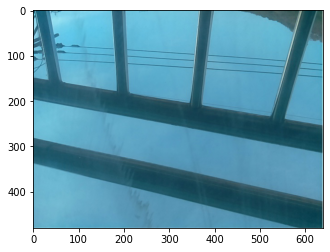

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'str'>
<class '_io.BufferedReader'>


In [13]:
# msg_recieved = json.load("txt_output_16.txt")

with open('txt_output_16.txt') as json_file:
    json_recieved = json.load(json_file)
    print(type(json_recieved))
    
    latitude = json_recieved.get("latitude")
    longitude = json_recieved.get("longitude")
    time_cctv = json_recieved.get("time")
    img_cctv = json_recieved.get("image")

    current_cctv = CctvData(latitude, longitude, time_cctv, img_cctv)

    print(current_cctv)
    #json.loads(mqtt ~~)
    
#     base64.b64decode(current_cctv.get_img())

#     ndarray = img.imread(base64.b64decode(img_cctv.encode('utf-8')))
#     ndarray = np.
#     plt.imshow(base64.b64decode(img_cctv.encode('utf-8')))
#     plt.show()

#     img_ecd = img_cctv.encode('utf-8')
#     print(img_cctv[:30],img_cctv[-30:],img_cctv[-1])
#     print(img_ecd[:30])
#     print(type(img_cctv),type(img_ecd))
    
#     print("-------------------")
    
#     en_img = img_cctv.encode('utf-8')
#     print(en_img[:30])
#     print(type(msg.payload[:40]))

#     test = np.array(en_img)
#     plt.imshow(base64.b64decode(test))
#     plt.imshow(test)
#     plt.show()

    
    # 이후: byte배열을 이미지로 변환하고 request_kakao_api() 호출
    
    
    
#     imgdata = base64.b64decode(str(base64_string))
#     image = Image.open(io.BytesIO(imgdata))
#     return cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)


#     img_cvrt = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
    
#     cv2.imshow('Image', img_cvrt)
#     cv2.waitKey(0)
    
    imgdata = base64.b64decode(str(img_cctv))
#     image = Image.open(io.BytesIO(imgdata))
#     print(image)
#     plt.imshow(image)
#     plt.show()
    
#     test = np.array(en_img)
#     plt.imshow(imgdata)
#     plt.show()
    print( type(imgdata) )
    image = Image.open(io.BytesIO(imgdata))
    image.save("./test.jpg")
#     image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB) #not required
    plt.imshow(image)
    plt.show()
    
    print(type(image)) # <class 'PIL.JpegImagePlugin.JpegImageFile'>
    print(type(img_cctv)) # <class 'str'>
    
with open('/home/lab24/smoke/image/image_action_45/image_45-1/45-1/45-1_001-C01/45-1_001-C01_009.jpg', 'rb') as f:
    print(type(f)) #<class '_io.BufferedReader'>
    

In [ ]:
curl -v -X POST "https://cv-api.kakaobrain.com/pose" \
  -H "Content-Type: multipart/form-data" \
  -H "Authorization: KakaoAK {REST_API_KEY}" \
  -F "file=@example_pose.jpg" 


POST /pose HTTP/1.1
Host: cv-api.kakaobrain.com 
Authorization: KakaoAK {REST_API_KEY} 

In [106]:
import requests, json
from tempfile import TemporaryFile
from PIL import Image
from requests import Session

# BASE_URI = 'https://cv-api.kakaobrain.com/pose'
with open("./Kakao-API-Key.txt") as REST_API_KEY:
    APP_KEY = REST_API_KEY

# imagePath = 'file=@' + test_path
# test_path = '/home/lab24/smoke/image/image_action_45/image_45-1/45-1/45-1_001-C01/45-1_001-C01_019.jpg'
test_path = './img/output_266.jpg'




with open(test_path, 'rb') as f:
    print(f)
    print(image)


    
# IMAGE_FILE_PATH = test_path

img_fp = TemporaryFile()
image.save(img_fp, "PNG")
img_fp.seek(0)

print(img_fp) # <_io.BufferedRandom name=67>


IMAGE_FILE = img_fp

result = request_kakao_api(IMAGE_FILE)
print_json(result)

img_fp.close()


# img_fp.close()

FileNotFoundError: [Errno 2] No such file or directory: './img/output_266.jpg'

In [107]:
import requests, json
from tempfile import TemporaryFile
from PIL import Image
from requests import Session

# BASE_URI = 'https://cv-api.kakaobrain.com/pose'
with open("./Kakao-API-Key.txt") as REST_API_KEY:
    APP_KEY = REST_API_KEY

# imagePath = 'file=@' + test_path
test_path = '/home/lab24/smoke/image/image_action_45/image_45-1/45-1/45-1_001-C01/45-1_001-C01_009.jpg'




with open(test_path, 'rb') as f:
    print(f)
    print(image)




img_fp = TemporaryFile()
image.save(img_fp, "PNG")
img_fp.seek(0)

print(img_fp)


# fp.close()
####################################


def print_json(obj):
    """Print the object as json"""
    print(json.dumps(obj, sort_keys=True, indent=2, separators=(',', ': ')))

    
# print(img_cctv)


# APP_KEY = REST_API_KEY
session = Session()
session.headers.update({'Authorization': 'KakaoAK ' + APP_KEY})


def request_kakao_api(filename):
    with open(filename, 'rb') as f:
        print(f)
        response = session.post('https://cv-api.kakaobrain.com/pose', files={'file': f})
        response.raise_for_status()
        return response.json()

IMAGE_FILE_PATH = test_path
result = request_kakao_api(IMAGE_FILE_PATH)
print_json(result)


# json_recieved = json.load(result)

#     print(type(json_recieved[0]))
#     print(json_recieved[0])
#     print(json_recieved[0]['keypoints'])
#     print("-----------------------------------------")

# need to check if none
# if non -> continue

# [x, y, w, h]
body_box = np.array(result[0]['bbox'])
# [x_1, y_1, score_1, x_2, y_2, score_2, ..., x_17, y_17, score_17]
keypoint = np.array(result[0]['keypoints'])
# reliability
score = result[0]['score']

# print(len(body_box))
# print(len(keypoint))

# print all the data
#     print(type(body_box[0]))
#     print(body_box)

#     print(type(keypoint[0]))
#     print(keypoint)

#     print(type(score))
#     print(score)

# make keypoint of [x][3] array
keypoint_mod = keypoint.reshape(-1, 3)
print(len(keypoint_mod))






    
# url = 'https://cv-api.kakaobrain.com/pose'
# # params = {'file': test_path}
# params = {'file': io.BytesIO(imgdata)}
# headers = { "Authorization": "KakaoAK " + REST_API_KEY,
#             "Content-Type": "multipart/form-data"
#           }

##################################
# with open('/home/lab24/smoke/image/image_action_45/image_45-1/45-1/45-1_001-C01/45-1_001-C01_009.jpg', 'rb') as f:
#     print(type(f))
        
#     url = 'https://cv-api.kakaobrain.com/pose'
#     # params = {'file': test_path}
#     params = {'file': f}
#     headers = { "Authorization": "KakaoAK " + REST_API_KEY,
#                 "Content-Type": "multipart/form-data"
#               }
    
#     try:
#         response = requests.post(url, params=params, headers=headers)
#         response.raise_for_status()
#         print_json(response.json())
#     except Exception as ex:
#         raise ex

######################################
# try:
#     response = requests.post(BASE_URI, headers=SUBSCRIPTION_KEY, =file)
#     response.raise_for_status()
#     print_json(response.json())
    
# except Exception as ex:
#     raise ex
    

    
###############################




# def request_kakao_api(data_cctv):

# def getSkeletonFromKakao(data_cctv):
#     result = ""
 
#     url = 'https://cv-api.kakaobrain.com/pose'
#     params = {'file': test_path}
#     headers = { "Authorization": "KakaoAK " + REST_API_KEY,
#                 "Content-Type": "multipart/form-data"
#               }
 
#     r = requests.get(url, params=params, headers=header)
    

#     if r.status_code == 200:
#         result_address = r.json()["documents"][0]["address"]
        
#         result = result_address["y"], result_address["x"]
#     else:
#         result = "ERROR[" + str(r.status_code) + "]"
    
#     return result



<_io.BufferedReader name='/home/lab24/smoke/image/image_action_45/image_45-1/45-1/45-1_001-C01/45-1_001-C01_009.jpg'>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7F68E065AFD0>
<_io.BufferedRandom name=65>
<_io.BufferedReader name='/home/lab24/smoke/image/image_action_45/image_45-1/45-1/45-1_001-C01/45-1_001-C01_009.jpg'>
[
  {
    "area": 176938.8167,
    "bbox": [
      851.9,
      46.2295,
      235.2,
      752.2909
    ],
    "category_id": 1,
    "keypoints": [
      991.5,
      124.2614,
      0.8758,
      997.5,
      108.9205,
      0.8507,
      973.5,
      108.9205,
      0.8609,
      952.5,
      118.125,
      0.0083,
      937.5,
      118.125,
      0.8928,
      1006.5,
      204.0341,
      0.7071,
      886.5,
      222.4432,
      0.7094,
      1066.5,
      277.6704,
      0.7628,
      871.5,
      348.2386,
      0.7751,
      1018.5,
      185.625,
      0.6774,
      889.5,
      446.4204,
      0.7422,
      1015.5,
      424.9432,
 

In [98]:
import json


# def convert_joint_info(keypoint):
    


with open('kakaopose-result_45-1_001-C01_009.txt') as json_file2:
    json_recieved = json.load(json_file2)
#     print(type(json_recieved[0]))
#     print(json_recieved[0])
#     print(json_recieved[0]['keypoints'])
#     print("-----------------------------------------")
    
    # need to check if none
    # if non -> continue
    
    # [x, y, w, h]
    body_box = np.array(json_recieved[0]['bbox'])
    # [x_1, y_1, score_1, x_2, y_2, score_2, ..., x_17, y_17, score_17]
    keypoint = np.array(json_recieved[0]['keypoints'])
    # reliability
    score = json_recieved[0]['score']

    print(len(body_box))
    print(len(keypoint))

    # print all the data
#     print(type(body_box[0]))
#     print(body_box)
    
#     print(type(keypoint[0]))
#     print(keypoint)
    
#     print(type(score))
#     print(score)
    
    # make keypoint of [x][3] array
    keypoint_mod = keypoint.reshape(-1, 3)
    print(keypoint_mod)
    
    

4
17.0
[[9.915000e+02 1.242614e+02 8.758000e-01]
 [9.975000e+02 1.089205e+02 8.507000e-01]
 [9.735000e+02 1.089205e+02 8.609000e-01]
 [9.525000e+02 1.181250e+02 8.300000e-03]
 [9.375000e+02 1.181250e+02 8.928000e-01]
 [1.006500e+03 2.040341e+02 7.071000e-01]
 [8.865000e+02 2.224432e+02 7.094000e-01]
 [1.066500e+03 2.776704e+02 7.628000e-01]
 [8.715000e+02 3.482386e+02 7.751000e-01]
 [1.018500e+03 1.856250e+02 6.774000e-01]
 [8.895000e+02 4.464204e+02 7.422000e-01]
 [1.015500e+03 4.249432e+02 6.545000e-01]
 [9.315000e+02 4.341477e+02 6.469000e-01]
 [1.024500e+03 5.875568e+02 7.562000e-01]
 [9.225000e+02 5.967614e+02 7.335000e-01]
 [1.009500e+03 7.225568e+02 7.603000e-01]
 [9.255000e+02 7.348295e+02 7.502000e-01]]


In [32]:
with open('1-10_001-C12_2D.json', 'rb') as test_json:
    annotation_data = json.load(test_json)


    print(type(annotation_data))
    print(len(annotation_data['annotations']))
    print(annotation_data['annotations'][0])
#     print(json.dumps(annotation_data, indent=2, sort_keys=True))
    print("-----------------------------------------")
    
#     annotations = np.array(annotation_data['annotations'])

    # [x, y, w, h]
    body_box = np.array(annotation_data['annotations'][0]['bbox'])
    # [x_1, y_1, view, x_2, y_2, view, ..., x_16, y_16, view]
    keypoint = np.array(annotation_data['annotations'][0]['keypoints'])
    keypoint_mod = keypoint.reshape(-1, 3)
    # number of keypoints
    num_keypoint = annotation_data['annotations'][0]['num_keypoint']

#     print(len(body_box))
#     print(body_box)
    print(len(keypoint_mod))
    print(keypoint_mod)
    
    #데이터값이 int형으로 되어있는 것을 
    

<class 'dict'>
30
{'img_no': 3113492, 'person_no': 1, 'bbox': [908.0, 323.0, 1061.0, 720.0], 'keypoints': [961.0, 638.0, 2.0, 955.0, 583.0, 2.0, 961.0, 509.0, 2.0, 999.0, 515.0, 2.0, 1014.0, 604.0, 2.0, 1022.0, 671.0, 2.0, 980.0, 512.0, 2.0, 982.0, 440.0, 2.0, 983.0, 392.0, 2.0, 988.0, 332.0, 2.0, 925.0, 509.0, 2.0, 931.0, 460.0, 2.0, 942.0, 408.0, 2.0, 1023.0, 408.0, 2.0, 1026.0, 471.0, 2.0, 1029.0, 520.0, 2.0], 'num_keypoint': 16}
-----------------------------------------
16
[[ 961.  638.    2.]
 [ 955.  583.    2.]
 [ 961.  509.    2.]
 [ 999.  515.    2.]
 [1014.  604.    2.]
 [1022.  671.    2.]
 [ 980.  512.    2.]
 [ 982.  440.    2.]
 [ 983.  392.    2.]
 [ 988.  332.    2.]
 [ 925.  509.    2.]
 [ 931.  460.    2.]
 [ 942.  408.    2.]
 [1023.  408.    2.]
 [1026.  471.    2.]
 [1029.  520.    2.]]


In [ ]:
# KAKAO API RESULT :  COCO(Common Objects in Context) dataformat
# 1	nose 9
# 2	left_eye (not used) 99
# 3	right_eye (not used) 99
# 4	left_ear (not used) 99
# 5	right_ear (not used) 99 
# 6	left_shoulder 13
# 7	right_shoulder 12
# 8	left_elbow 14
# 9	right_elbow 11
# 10	left_wrist 15
# 11	right_wrist 10
# 12	left_hip 3 
# 13	right_hip 2
# 14	left_knee 4
# 15	right_knee 1
# 16	left_ankle 5
# 17	right_ankle 0
## 17개

# for AI Hub dataformat
# 0 right_ankle 17
# 1 right_knee 15
# 2 right_hip 13
# 3 left_hip 12
# 4 left_knee 14
# 5 left_ankle 16
    # 6: hip(not used)
    # 7: chest(not used)
    # 8: neck
# 9 head (nose 1)
# 10 right_wrist 11
# 11 right_elbow 9
# 12 right_shoulder 7
# 13 left_shoulder 6
# 14 left_elbow 8
# 15 left_wrist 10
## 16개

In [99]:
# print(AI_TO_COCO[0][AIHUB])
# print(AI_TO_COCO[0][KakaoCOCO])
# print(len(AI_TO_COCO))
# print(AI_TO_COCO)

def convert_annotation_to_aihub(keypoint):
    COCO_TO_AI = (
        (0,9),  (1,99),
        (2,99), (3,99),
        (4,99), (5,13),
        (6,12), (7,14),
        (8,11), (9,15),
        (10,10),(11,3),
        (12,2), (13,4),
        (14,1), (15,5),
        (16,0)
    )
    KakaoCOCO = 0
    AIHUB = 1
    
    new_keypoint = np.zeros(shape=(16,3))
#     print(new_keypoint)
    
    for cnt in range(0, 17):
        AI = COCO_TO_AI[cnt][AIHUB]
        COCO = COCO_TO_AI[cnt][KakaoCOCO]
#         print(str(cnt) + ' ')
#         print(str(COCO) + ' ' + str(AI))
        
        if (AI==99):
            continue
        new_keypoint[AI][0] = keypoint[COCO][0]
        new_keypoint[AI][1] = keypoint[COCO][1]
        new_keypoint[AI][2] = keypoint[COCO][2]*100
    
    keypoint_int = np.round(new_keypoint, 0)
    keypoint_int = np.asarray(keypoint_int, dtype = int)
    return keypoint_int
    
    
        

def convert_annotation_to_coco(keypoint):
    AI_TO_COCO = (
        (0,17-1), (1,15-1),
        (2,13-1), (3,12-1),
        (4,14-1), (5,16-1),
        (6,99),   (7,99),
        (8,99),   (9,1-1),
        (10,11-1),(11,9-1),
        (12,7-1), (13,6-1),
        (14,8-1), (15,10-1)
    )
    AIHUB = 0
    KakaoCOCO = 1
#     print(len(keypoint))
    
    new_keypoint = np.zeros(shape=(16,3))
#     print(new_keypoint)
    
    for cnt in range(0, 16):
        AI = AI_TO_COCO[cnt][AIHUB]
        COCO = AI_TO_COCO[cnt][KakaoCOCO]
        
        if (COCO==99):
            continue

        new_keypoint[COCO][0] = keypoint[AI][0]
        new_keypoint[COCO][1] = keypoint[AI][1]
        new_keypoint[COCO][2] = keypoint[AI][2]
    
    keypoint_int = np.round(new_keypoint, 0)
    keypoint_int = np.asarray(keypoint_int, dtype = int)
    return keypoint_int
    
    





keypoint_mod1 = convert_annotation_to_aihub(keypoint_mod)
print(keypoint_mod1)
print(len(keypoint_mod1))

# keypoint_mod2 = convert_annotation_to_coco(keypoint_mod)
# print(str(keypoint_mod2) + '\n')  
# print


[[ 926  735   75]
 [ 922  597   73]
 [ 932  434   65]
 [1016  425   65]
 [1024  588   76]
 [1010  723   76]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [ 992  124   88]
 [ 890  446   74]
 [ 872  348   78]
 [ 886  222   71]
 [1006  204   71]
 [1066  278   76]
 [1018  186   68]]
16


In [ ]:
# def swap_annotation_to_aihub(keypoint):
    
    
    
# def swap_annotation_to_coco(keypoint):

In [103]:
# from enum import Enum

# for AI Hub dataformat
# class AIHUB(Enum):
#     RIGHT_ANKLE = 0
#     RIGHT_KNEE = 1
#     RIGHT_HIP = 2
#     LEFT_HIP = 3
#     LEFT_KNEE = 4
#     LEFT_ANKLE = 5
#     HIP = 6 # NOT EXIST
#     CHEST = 7 # NOT EXIST
#     NECK = 8 # NOT EXIST
#     NOSE = 9 # HEAD (NOSE 1)
#     RIGHT_WRIST = 10
#     RIGHT_ELBOW = 11
#     RIGHT_SHOULDER = 12
#     LEFT_SHOULDER = 13
#     LEFT_ELBOW = 14
#     LEFT_WRIST = 15

# for val in AIHUB:
#     print(val.value)
# print(AIHUB[RIGHT_KNEE])

# #########################

# # AIHUB_list = ( 'RIGHT_ANKLE',
# #     'RIGHT_KNEE',
# #     'RIGHT_HIP',
# #     'LEFT_HIP',
# #     'LEFT_KNEE',
# #     'LEFT_ANKLE',
# #     'HIP',
# #     'CHEST',
# #     'NECK',
# #     'NOSE',
# #     'RIGHT_WRIST',
# #     'RIGHT_ELBOW',
# #     'RIGHT_SHOULDER',
# #     'LEFT_SHOULDER',
# #     'LEFT_ELBOW',
# #     'LEFT_WRIST')
# # print(AIHUB_list)

# #########################

# # KAKAO API RESULT :  COCO(Common Objects in Context) dataformat
# class KakaoCOCO(Enum):
#     NOSE = 1
#     LEFT_EYE = 2 # (NOT USED)
#     RIGHT_EYE = 3 # (NOT USED)
#     LEFT_EAR = 4 # (NOT USED)
#     RIGHT_EAR = 5 # (NOT USED)
#     LEFT_SHOULDER = 6
#     RIGHT_SHOULDER = 7
#     LEFT_ELBOW = 8
#     RIGHT_ELBOW = 9
#     LEFT_WRIST = 10
#     RIGHT_WRIST = 11
#     LEFT_HIP = 12
#     RIGHT_HIP = 13
#     LEFT_KNEE = 14
#     RIGHT_KNEE = 15
#     LEFT_ANKLE = 16
#     RIGHT_ANKLE = 17

# for val in KakaoCOCO:
#     print(val.value)

SyntaxError: invalid syntax (2564324321.py, line 3)

In [ ]:
# BASE_URI = 'https://api.cognitive.microsoft.com/bing/v7.0/images/visualsearch'
# # 이부분을 DB서버로

# SUBSCRIPTION_KEY = 'your-subscription-key'
# # Data = JSON 파일



# APP_KEY = REST_API_KEY
# session_DB = Session()
# session_DB.headers.update({}) # 뭔가 인증 같은게 필요하다면 이 부분에서 이루어질듯함



# def request_smoke_database(CCTV_data):
#     # current_cctv의 데이터를 send format에 맞게 수정 후 발송
    
#     # JSON Send Format:
#     # {
#     #     "latitude": "37.5683",
#     #     "longitude": "126.9778",
#     #     "time": "2021-11-17 13:25:02.066349"
#     # }
#     response = session_DB.post(BASE_URI, files={'file': send_data} userid = asdf passwd = sdfasdf )
#     response.raise_for_status()
#     return response.json()


# result = request_smoke_database(current_cctv)
# print_json(result)

In [4]:
# Module Imports
# import mariadb
import mysql.connector as mariadb
import sys

# Connect to MariaDB Platform
try:
    mariadb_conn = mariadb.connect(
        database="conv_project",
        user="user_ai",
        password="1234",
        host="3.104.139.205",
        port=3306,

    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

# Get Cursor
mariadb_cur = mariadb_conn.cursor()

sql = '''
    DESC dashboard_dashboard
'''

# sql = '''
#     SHOW TABLES
# '''

mariadb_cur.execute(sql)
a = mariadb_cur.fetchall()
print(a)
# print(a[1])
# print(a[2][0])

[('id', 'bigint(20)', 'NO', 'PRI', None, 'auto_increment'), ('longitude', 'varchar(100)', 'NO', '', None, ''), ('latitude', 'varchar(100)', 'NO', '', None, ''), ('time', 'datetime', 'NO', '', None, '')]


In [3]:
sql = '''
    CREATE TABLE dashboard_test(
        ID BIGINT(20) PRIMARY KEY AUTO_INCREMENT,
        LONGITUDE VARCHAR(100),
        LATITUDE VARCHAR(100),
        TIME DATETIME)
'''

mariadb_cur.execute(sql)
a = mariadb_cur.fetchall()
print(a)

[]


In [4]:
sql = '''
    DESC dashboard_test
'''

mariadb_cur.execute(sql)
a = mariadb_cur.fetchall()
print(a)

[('ID', 'bigint(20)', 'NO', 'PRI', None, 'auto_increment'), ('LONGITUDE', 'varchar(100)', 'YES', '', None, ''), ('LATITUDE', 'varchar(100)', 'YES', '', None, ''), ('TIME', 'datetime', 'YES', '', None, '')]


In [15]:
sqlInsert = "INSERT INTO dashboard_test (LATITUDE, LONGITUDE, TIME) values (%s, %s, %s)"
valueInsert1 = (current_cctv.get_lat(), current_cctv.get_long(), current_cctv.get_time())
# valueInsert2 = ('3', 'ayotera')

mariadb_cur.execute(sqlInsert, valueInsert1)
# mariadb_cur.execute(sqlInsert, valueInsert2)
mariadb_conn.commit()


#     #     "latitude": "37.5683",
#     #     "longitude": "126.9778",
#     #     "time": "2021-11-17 13:25:02.066349"



In [5]:
sqlSelect = '''
    SELECT * FROM dashboard_test
'''

mariadb_cur.execute(sqlSelect)
a = mariadb_cur.fetchall()
print(a)

[(1, '126.9778', '37.5683', datetime.datetime(2021, 11, 17, 13, 25, 2)), (3, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (4, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (5, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (6, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (7, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (8, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (9, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (10, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (11, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (12, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 30)), (13, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 31)), (14, '126.9778', '37.5683', datetime.datetime(2021, 11, 26, 10, 39, 31)), (15, '126.9778', '37.5683', datetime.datetime(